# IPCC Tier 2 method LB (Living Biomass) increase simulation for afferestation on cropland and grassland

In this example notebook the impact on the LB for a certain prototype configuration will be calculated and visualized.
This notebook is developed in such a way, that that user can play around with different configurations and analyze the outcome.

The **IPCC** layers and and needed LUT tables will be used in the first place to enable this simulation

#### Load and (install) used packages

In [14]:
import os
import glob
from pathlib import Path
import geopandas as gpd
from loguru import logger
from pathlib import Path
import geopandas as gpd
import sys
import matplotlib.pyplot as plt
import logging
import rasterio
import rasterio.mask
import numpy as np
import gdal
import subprocess
import osr
import pandas as pd

#### Load defined variables and functions

In [15]:
### location of the code to run the scenarios
sys.path.append(Path(os.getcwd()).parent.joinpath('src').as_posix())
from SOC_scenarios.utils.soc_helper_functions import *
from constants import (
    type_method,
    dict_C_pool_mng_options
)

from Biomass.utils.biom_helper_functions import *
sys.path.append(Path(os.getcwd()).parent.joinpath('Scripts').as_posix())
from SOC.SOC_stratification import SOC_strat_IPCC_block_proc
from Biomass.run_afforestation_scenario import afforestation_LUT_block_proc

#### IPCC LB calculation when afforesation part of the cropland and grassland

The IPCC formula listed below forms the basis of this living biomass increase calculation a for certain tree species. The formula is retrieved from the following IPCC document (pg.15) : https://www.ipcc-nggip.iges.or.jp/public/2006gl/pdf/4_Volume4/V4_02_Ch2_Generic.pdf 

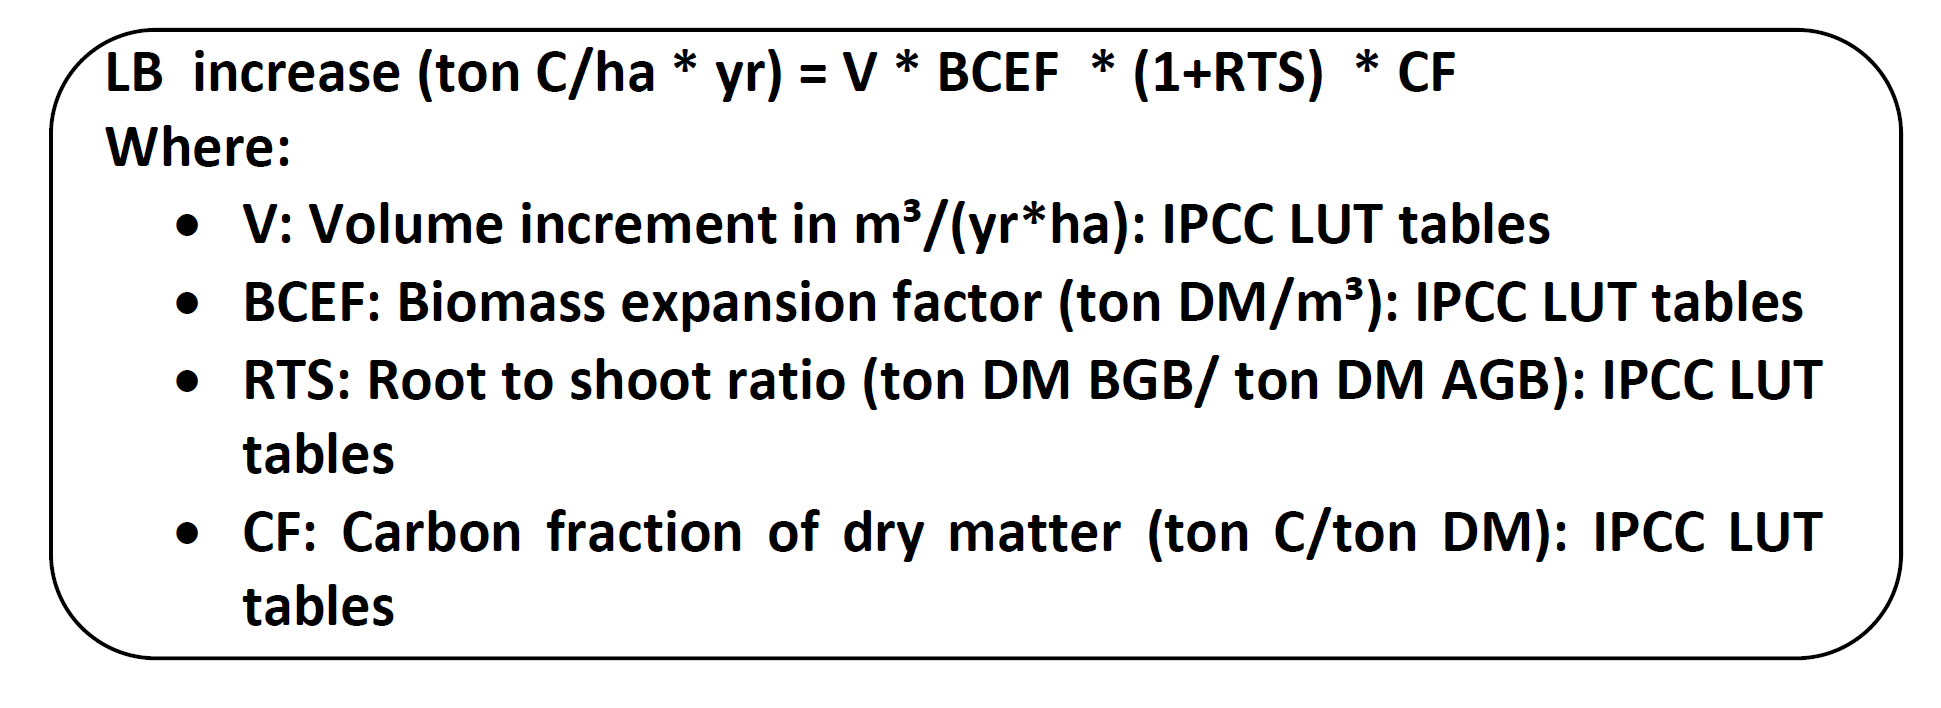
<br>

The corresponding paramters are derived from IPCC tables in case of the CF, BCEF and RTS, while the annual volume increment is retrieed from a yield table compiled by JRC based on national forest inventories datasets <br>

## PART1: CONFIGURE AFFORESTATION SCENARIO

### Options for configuration of afforestation scenario

Define the configuration for the flexible parameters that will determine the afforestation scenario


#### Slope

Threshold on slope for afforestation. Slopes above the defined threshold will be used for afforesation. Options between 0-87.5 (%)

#### RCP

The emission scenario of the EUTrees4F that will be used for the future occurrence probability of a certain tree species. Default take the 'rcp45' scenario

#### Tree_prob
The probability of occurrence that a certain tree species should have in a certain target year before it can be used for afforestation. Options between 0-100 (%)

#### Tree_species

The tree species you want to use for the afforestation. Full lust please consult JRC LUT

* **Fagus_sylvatica** <br>

* **Larix_decidua** <br>

* **Picea_abies** <br>

* **Pinus_pinaster** <br>

* **Pinus_sylvestris** <br>

* **Quercus_robur** <br>


#### Perc_reforest

The percentage of suitable (determined by the afforestation mask) grassland/cropland that should be afforested. Options between 0-100 (%)

#### Year_potential
The target year for which the afforestation carbon sequestration potential calculation should be done (2024 -...)

#### Year_baseline
The baseline year for which the afforestation carbon sequestration potential calculation should start and thus the year at which the trees will be planted


#### lst_CLC_afforestation
Define which CLC classes can be used for afforestation
Based on the column 'Afforestation_mask' from CLC_LULUCF table: https://eea1.sharepoint.com/:x:/r/teams/-EXT-CrossETCexchange/_layouts/15/Doc.aspx?sourcedoc=%7B447d1502-9f54-43e2-900a-14a239770769%7D&action=edit&wdLOR=cAE9313DD-6E50-40F6-A328-F1101ABF05EE&activeCell=%27CLC_LULUCF_LUT%27!G30&wdinitialsession=73a03156-95ab-4412-8a03-e3ccd81233d7&wdrldsc=2&wdrldc=1&wdrldr=AccessTokenExpiredWarning%2CRefreshingExpiredAccessT&cid=16243ca6-b7d4-411f-9dd8-924b725e256a



<br> The use of **NUTS specific** factors can be enabled by setting the parameter **'run_NUTS_specific_scenario' on True**.
<br> Please be aware that in that case a LUT should be established which assign a specific configuration to each NUTS region. 
<br> Currently, a randomly defined configuration in the data folder 'NUTS_LUT_afforestation_scenario' will be loaded. 


#### First prototype configuration:

This is the initial configuration that was used to generate the afforestation maps <br>

'Slope': 0, <br>
'RCP': 'rcp45', <br>
'Tree_prob': 70, <br>
'Tree_species': 'Betula_pendula', <br>
'Perc_reforest': 10, <br>
'Year_potential': 2035, <br>
'input_source': 'EEA39'} <br>

   
the input_source parameter just indicates that this is the default configuration at EEA39 scale. If a NUTS specific scenario is enabled this will be set to the NUTS level for which this parameter is defined.

In [16]:
## now this configuration will be put into a dictionary

Year_potential = 2035
Year_baseline = 2023

# define which management action is applied
mng_option = 'afforestation'

# load the carbon pool that is targeted here
carbon_pool = dict_C_pool_mng_options.get(mng_option)

# List of CLC classes (LEVEL-3) that can be used for afforestation
lst_CLC_afforestation = [211, 212, 213, 231]

dict_default_afforestation_factors = {
        'Slope': 0,
        'RCP': 'rcp45',
        'Tree_prob': 70,
        'Tree_species': 'Betula_pendula',
        'Perc_reforest': 10,
        'Year_potential': Year_potential,
        'input_source': 'EEA39'}

SCENARIO_SPECS = {
        'mng_option': mng_option, 
        'Year_potential': Year_potential,
        'Year_baseline': Year_baseline,
        'carbon_pool': carbon_pool, # Living biomass pool
        'lst_CLC_affor': lst_CLC_afforestation,
        'afforestation_config': dict_default_afforestation_factors
    }

## PART2: CONFIGURE PROCESSING SETTINGS


In [17]:
# Define if the results should be created by block-based
# processing, meaning only the window for the AOI (i.e., NUTS region) will
# be loaded

# Only this type of processing is supported for the moment!!!
block_based_processing = True

# Country_running
Country = None  # set to None if want to run entire EEA39 extent 

# suffix of the output raster and ID that is
# used to distinguish different scenario runs
scenario_name = f'Scenario_JRCV2_{str(Year_potential)}_fix'

# if want to run with some NUTS specific factors
# set the below parameter to true
# if a country is defined only the NUTS regions
# in that country will be considered
run_NUTS_specific_scenario = False

# Indicate if stats at NUTS LEVEL need to be provided
# this will be witten in shapefile format and saved
add_stats_NUTS_level = True


# define if the result might be overwritten
overwrite = False

# the location of the basefolder in which all the input data needed for the simulation is provided
#!!!!!! Should be changed once know central location for data access
Basefolder_input_data = os.path.join(os.getcwd(), 'data')

### the basefolder in which all the output results will be stored
#!!!!!! Should be changed once know central location for data access
Basefolder_output =  os.path.join(os.getcwd(), 'output')

# the name of the drive on which all the data can be accessed:
dir_signature = os.getcwd()

# location where the NUTS specific configuration for afforesation is stored
#!!!!!! Should be changed once know central location for data access
NUTS_LUT_factors_folder = os.path.join(Basefolder_output,'NUTS_LUT_afforestation_scenario')

# define the yield table LUT and forest zone LUT
# location that should be used for processing
#!!!!!! Should be changed once know central location for data access
name_yield_table_LUT = 'LUT_C_SEQ_AFFOR_JRC_V2.csv'
name_LUT_forest_zones = 'LUT_FOREST_ZONE.csv'
folder_JRC_table = os.path.join(Basefolder_output, 'NUTS_LUT_afforestation_scenario',
                                'JRC_yield_table')
yield_table_LUT_dir = os.path.join(folder_JRC_table, name_yield_table_LUT)
forest_zone_dir = os.path.join(folder_JRC_table, name_LUT_forest_zones)


CONFIGURATION_SPECS = {
    'block_based_processing': block_based_processing,
    'Country': Country,
    'scenario_name': scenario_name,
    'yield_table_dir': yield_table_LUT_dir,
    'forest_zone_dir': forest_zone_dir,
    'run_NUTS_SPECIFIC': run_NUTS_specific_scenario,
    'add_stats_NUTS': add_stats_NUTS_level,
    'scaling': 100,
    'NUTS_LUT_folder': NUTS_LUT_factors_folder,
    'overwrite': overwrite,
    'dir_signature': dir_signature,
    'type_method': type_method,
    'Basefolder_output': Basefolder_output,
    'Basefolder_input': Basefolder_input_data
}

## PART3: DEFINE REQUIRED DATASETSS

In [18]:
"""Load the datasets needed for running the scenario"""

# Define processing extent
### TODO: Fill in the location that you stored these files locally!!!
## location with the EEA39 extent
EEA_extent_layer = gpd.read_file(os.path.join(Basefolder_input_data, 'AOI', 'EEA39_extent_noDOM.shp'))

### TODO: Fill in the location that you stored these files locally!!!
VECTORS = {'NUTS':os.path.join(Basefolder_input_data, 'NUTS', 'NUTS_RG_20M_2021_3035.shp'),
           'EEA_extent': EEA_extent_layer}

"""Load the datasets needed for afforestation mask"""

# Below define the locations of the
# rasters needed for the afforestation mask

#### Below the paths to the files needed for the afforestation mask will be defined 
### TODO: Fill in the location that you stored these files locally!!!
DEM_location = os.path.join('/data', 'inca_vol1', 'input_data', 'wood_provision',
                                'input_intermediate', 'DEM', 'dt1_slope_INCA_100m_EPSG3035.tif')
N2K_location = os.path.join('/data', 'inca_vol1', 'input_data', 'wood_provision',
                                'input_intermediate', 'N2K', 'N2K_2018_100m.tif')
# if a region specific external mask is available,
# please insert it below otherwise set it to 'None'
# !! Please ensure that all the rasters are on the same grid
external_mask = None


########## TODO: ETC/DI #############

"""
Following additional dtaatsets should be implemented to identify those areas 
that should be protected for afforestation:
* Nationally designated areas (CDDA): Protected areas should be EXCLUDED for afforestation
* High nature value farmland 2012: High nature value farmland should be EXCLUDED for afforestation
* Extended wetland layer (2018): Any wetland should be EXCLUDED for afforestation
* Peatland map (2017): Tanneberger peatland map --> peatland should be EXCLUDED for afforestation


The abandoned cropland locations should be PRIORITIZED for afforestation if is has been found suitable
for afforestation based on the afforestation mask
"""


### TODO: Fill in the location that you stored these files locally!!!
CLC_dir = os.path.join(os.getcwd(), 'data', 'CLC_ACC', 'CLC2018ACC_V2018_20.tif')

DATASETS_afforestation = {'DEM': DEM_location,
                          'N2K': N2K_location,
                          'external_mask': external_mask,
                          'CLC': CLC_dir}

"""Load the datasets needed for defining afforestation suitability of tree species"""

# Below define the raster(s) for defining the suitability
#  of planting a certain tree species

## Load the basefolder of the EU4Trees dataset
### TODO: Fill in the location that you stored these files locally!!!
EU4Trees_base = os.path.join('/data','inca_vol1', 'etc', 'lulucf', 'input_data',
                             'EU-Trees4F', 'ens_sdms', 'prob', 'resampled')
DATASETS_AFFORESTATION_SUITABILTY = {
    'EU4Trees': EU4Trees_base
}

"""Load IPCC datasets needed to assign strata specific increment values"""

# Put all the IPCC related datasets used for
# strata based assigned using the LUT

## the directory of the IPCC climate  
### TODO: Fill in the location that you stored these files locally!!!

IPCC_climate_raster = os.path.join(Basefolder_input_data, 'IPCC_layers', 'climate', 'ipcc_climate_zone_100m_EPSG3035_EEA39.tif') 


DATASETS_IPCC = {
    'CLIMATE_ZONES': IPCC_climate_raster,
}

DATASETS_SPECS = {
    'VECTORS': VECTORS,
    'AFFORESTATION_MASK': DATASETS_afforestation,
    'AFFORESTATION_SUITABILITY': DATASETS_AFFORESTATION_SUITABILTY,
    'IPCC_STRATIFICATION': DATASETS_IPCC
}

### Specify area of interest
(running on the entire EEA39 extent is not recommended in a Notebook environment due to memory limitations!) 
NUTS based processing of entire extent is possible, but in that case the **'run_NUTS_specific_scenario'** parameter should be set to True.

A NUTS3 region should be selected for processing (e.g. 'PL432').The original script located here: https://github.com/VITObelgium/ETC-CCA-LULUCF/blob/master/Scripts/Biomass/run_afforestation_scenario.py  will allow to run all different NUTS regions at country or EU level at once. This notebook examplifies just the workflow for one NUTS region. 

In [19]:
#select now the country of interest; if set to None the entire EEA39 extent will be processed
NUTS_region = 'CZ020'

# load the geometry of the specific NUTS region
NUTS_layer = gpd.read_file(VECTORS.get('NUTS'))
NUTS3_region = NUTS_layer.loc[((NUTS_layer.LEVL_CODE == 3) & (NUTS_layer.NUTS_ID == NUTS_region))].iloc[0,:]


# ASSING ALL THE ABOVE DEFINED CONDIGURATION INTO THE SETTINGS DICTIONARY WHICH WILL BE USED IN THE AFFORESTATION FUNCTIONS

settings = {'SCENARIO_SPECS': SCENARIO_SPECS,
            'CONFIG_SPECS': CONFIGURATION_SPECS,
            'DATASETS': DATASETS_SPECS,
            'commit_id': 'cb72cc9159d438f3e235e3e9c10e60dd2853f95c',
            'NUTS_region': NUTS_region,
            'NUTS3_info': NUTS3_region}

    

#### First define the afforestation mask for specified region

In [20]:
### Afforestation mask layer generation will be stored under the subfolder called 'Afforestation_mask'


########## TODO: ETC/DI #############

"""
Implementation of the following in the 'define_affor_areas' function
Following additional datasets should be implemented to identify those areas 
that should be protected for afforestation:
* Nationally designated areas (CDDA): Protected areas should be EXCLUDED for afforestation
* High nature value farmland 2012: High nature value farmland should be EXCLUDED for afforestation
* Extended wetland layer (2018): Any wetland should be EXCLUDED for afforestation
* Peatland map (2017): Tanneberger peatland map --> peatland should be EXCLUDED for afforestation


The abandoned cropland locations should be PRIORITIZED for afforestation if is has been found suitable
for afforestation based on the afforestation mask
"""
affor_mask_layer = define_affor_areas(settings)

#### Next calculate the annual living biomass increment 
Only the increment for the pixels for which the tree is able to grow and the afforestation mask is valid will be shown

In [21]:
## This output raster will be stored under the subfolder called 'LB_scenario'
affor_potential_layer, outname_affor_pot = create_affor_potential(settings, affor_mask_layer)

#### Next derive the stats that shows the average annual increment per land use category

In [22]:
df_stats_NUTS = calc_stats_biomass_NUTS(os.path.join(settings.get('CONFIG_SPECS').get('Basefolder_output'),'LB_scenario', settings.get('NUTS3_info')['CNTR_CODE'], settings.get('SCENARIO_SPECS').get('carbon_pool') + '_' + settings.get('CONFIG_SPECS').get('scenario_name') + '_{}.tif'.format(NUTS_region))
                                                , settings.get('NUTS3_info'),settings)

In [23]:
## Below you can find the printed results for yearly LB increase potential for cropland and grassland as well the number of pixels that will be used for afforestation as well some info on the applied configuration
# The yearly increase of LB is expressed in tonC/ha*yr while the LB_total in tonC/ha
print(df_stats_NUTS)

   LB_mean_yrly_age_0_20  LB_mean_yrly_age_21_30  nr_pixels  LB_total_2035  \
0                    2.6                    2.59    20159.1      628963.92   

  NUTS_ID  NUTS_LEVEL  Slope_factor Slope_src  Tree_prob Tree_prob_src  \
0   CZ020           3             0     EEA39         70         EEA39   

  Tree_species_factor Tree_species_src  perc_reforest perc_reforest_src  \
0      Betula_pendula            EEA39             10             EEA39   

     RCP  Year_potential                                           geometry  
0  rcp45            2035  POLYGON ((4685657.698899999 3058491.5413, 4685...  
